•features - наименовыния признаков

•w_init - вектор начальных весов модели

•eta - шаг градиентного спуска (по умолчанию 0.001)

•max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)

•max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу (по умолчанию 1e-8)

•seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)

•verbose - флаг печати информации (например, для отладки, по умолчанию False)

In [1]:
import numpy as np
import pandas as pd
from time import time

from thbmodel.utils import timestamp, YEAR, MONTH,settings
from thbmodel.utils.arrayview import ArrayView, TimeseriesView

from thbmodel.prediction.models.fit_model import TSModel
from thbmodel.prediction.models.model_parameters import ModelParameters
from thbmodel.prediction.models.factor_management import FactorList
from thbmodel.prediction.models.preprocessing import load_slices

from thbmodel.prediction.models.prediction import factornames_trimmed
from thbmodel.prediction.models.parameters import factor_build_end

In [2]:
def softmax(x, axis =1):
    """
    x <= [n,i] tensor 
    axis <= dimention for sum in softmax
    in case np.inf/np.inf = 1.
    return
    sf <= [n,i] tensor answer softmax along axis 
    """

    v_exp = np.exp(x)
    if axis ==1:
        sf = np.divide(v_exp, np.nansum(v_exp, axis =axis).reshape(-1,1))
    else:
        sf = np.divide(v_exp, np.nansum(v_exp, axis =axis))
    mask = np.isnan(sf)
    if mask.any():
        return np.where(mask, 1, sf)
    return sf

In [24]:
def G_step_factorize_T(df_t, winner, t_len, w, V, verbose=False):
    """ 
    Gradient step 
    return gradient 
    
    df <= [n,i,j] 3d tensor of datas (n) event, (i) -horse, (j) factor
    winner <=  [n,i] 2d tensor (matrix) (n) event, (i) -horse, value 1 if won event else 0
    t_len <= [n] 1d tensor (vector) (n) event, value number of horses in event
    w <=  [j] Model's parameters
    V <= [j,r] Model's parameters
    verbose <=  flaf debaging
    """
    b_size,h,f = df_t.shape
    
    S = np.einsum('nij, j -> ni', df_t,w) + np.einsum('nij, jr, kr, nik  -> ni', df_t,V,V,df_t)/2 - \
                np.einsum('nij, jr, jr, nij  -> ni', df_t,V,V,df_t)/2
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S) 
            
    delta = winner - p
    #dS_by_dV = np.einsum('nij,kr, nik -> nijr', df_t, V, df_t) - np.einsum('jr,nij -> nijr', V, df_t *df_t)
    
    grad_w = np.zeros_like(w)
    grad_V = np.zeros_like(V)
    
    x = np.where(np.isnan(df_t), 0, df_t)
    grad_w = np.einsum('ni, nij -> j', delta, x)
    dS_by_dV = np.einsum('nij,kr, nik -> nijr', x, V, x) - np.einsum('jr,nij -> nijr', V, x *x)
    #dS_by_dV = np.where(np.isnan(dS_by_dV), 0, dS_by_dV)
    grad_V = np.einsum('ni, nijr -> jr', delta, dS_by_dV)
        
    if verbose:
        print 'shape grad_w ',grad_w.shape
        print 'grad_w  ',grad_w[:10]

    if verbose:
        print 'shape grad_V  ',grad_V.shape
        print 'grad_V  ',grad_V[:10,0]
        print '---------------------------------------'
    
    return -np.divide(grad_w, b_size), -np.divide(grad_V, b_size)

In [4]:
def AdaMax_factorize_T(data, features,  w = None, V = None, b_size =1000, eta=1e-3, N_epoh =10, rang =2,
                                moment1 = 0.9, moment2 = 0.99, la = 0.8, max_iter=100,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск с моментом и вторым мометном
    выбираем  b_size скачек делаем шаг
    выбираем  b_size скачек делаем 2-й шаг и т.д.
    переходим все итерации
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  начальное приближение для параметров модели
    b_size  <=  размер бача
    eta <=  шаг обучения
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    eps <=  почти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """

    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
        w = np.random.normal(0, scale =1e-2, size =(len(features)))
        #w = np.ones((len(features)))* 0.01
        
    if V == None:
        V = np.random.normal(0, scale =1e-2, size =(len(features), rang))
        #V = np.ones((len(features), rang)) * 0.01
    n,m = V.shape
    #common vector parameters
    w_par = np.vstack((w.reshape(1,-1), V.T)).flatten()
    # Step
    
    # store of grad changes
    grad_norm = np.zeros(max_iter * N_epoh +1 +1)
    # last gradient value
    last_grad = np.zeros_like(w_par) 
    # last gradient's variation value
    std_grad = np.zeros_like(w_par)
    # unique events in data set
    events_list = np.unique(data['event_id'])
        
    # Main loop
    for i in range(N_epoh):
        # random choice the events size = b_size
        r_event = np.random.choice(events_list, size = b_size)
        df = data.loc[np.in1d(data['event_id'], r_event),:]
        
        df_t, winner_t, t_len = DF_to_tensor(df, features)
    
        
        for iter_num in range(1, max_iter+1):
        
            w_par_N = w_par- eta* moment1 *last_grad # for Nesterov momentum

            # get gradient with  Nesterov momemtum + L2 regularisation
            w = w_par_N[:n] # return to original shape
            V = w_par_N[n:].reshape(m, n).T
            #w = w_par[:n] # return to original shape
            #V = w_par[n:].reshape(m, n).T
        
            grad_values = G_step_factorize_T(df_t, winner_t, t_len, w, V, verbose=False) 
            
            grad_ = np.vstack((grad_values[0].reshape(1,-1), grad_values[1].T)).flatten() + la * w_par_N # gradient and L2
                
            last_grad = moment1 * last_grad + (1-moment1) * grad_ # Update weight first moment estimate 
            std_grad = np.max(np.vstack((moment2 * std_grad, np.abs(grad_))), axis =0) # Update weight second moment estimate 
            
            t = i * max_iter + iter_num
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
        
            grad_step = last_grad_/std_grad
            w_par = w_par - eta * grad_step
        
            weight_dist = np.linalg.norm(grad_step, ord=2)/len(w_par)
            grad_norm [t] = weight_dist 
        
            if (weight_dist <= min_weight_dist):
                print 'SGD covergence', t
                break
        
            if verbose:
                #print 'w  ', w
                if (t%(max_iter/2)) ==0:
                    print 'epoh {0}  iteration  {1}  dist {2}  V {3}'.format(i, t, weight_dist, w_par[54:56])

        
            if np.any((w == np.inf)|(w == -np.inf)):
                print "w overcome"
                return w, grad_norm , t
        
    return w_par, grad_norm , t

In [5]:
def Adam_factorize_T (data, features,  w = None, V = None, rang = 2, b_size =1000, eta=1e-3, 
                                moment1 = 0.9, moment2 = 0.99, la = 0.8, max_iter=100, N_epoh = 10,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск с моментом и вторым мометном
    в эпохе выбираем  b_size скачек делаем градиентный спуск  с максимумом итераций
    в следующей эпохе выбираем  b_size скачек делаем градиентный спуск
    
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  параметры модели (веса), вектор длинной = len(features)
    V <= фактаризационные параметры модели, матрица len(features) x rang
    b_size  <=  размер бача
    eta <=  шаг обучения
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    eps <=  почьти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """

    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
        w = np.random.normal(0, scale =1e-2, size =(len(features)))
        #w = np.ones((len(features)))* 0.01
        
    if V == None:
        V = np.random.normal(0, scale =1e-2, size =(len(features), rang))
        #V = np.ones((len(features), rang)) * 0.01
    n,m = V.shape
    #common vector parameters
    w_par = np.vstack((w.reshape(1,-1), V.T)).flatten()
    # Step
    
    # store of grad changes
    grad_norm = np.zeros(max_iter * N_epoh +1 +1)
    # last gradient value
    last_grad = np.zeros_like(w_par) 
    # last gradient's variation value
    std_grad = np.zeros_like(w_par)
    # unique events in data set
    events_list = np.unique(data['event_id'])
        
    # Main loop
    for i in range(N_epoh):
        # random choice the events size = b_size
        r_event = np.random.choice(events_list, size = b_size)
        df = data.loc[np.in1d(data['event_id'], r_event),:]
        
        df_t, winner_t, t_len = DF_to_tensor(df, features)
    
        
        for iter_num in range(1, max_iter+1):
        
            w_par_N = w_par- eta* moment1 *last_grad # for Nesterov momentum

            # get gradient with  Nesterov momemtum + L2 regularisation
            w = w_par_N[:n] # return to original shape
            V = w_par_N[n:].reshape(m, n).T
            #w = w_par[:n] # return to original shape
            #V = w_par[n:].reshape(m, n).T
        
            grad_values = G_step_factorize_T(df_t, winner_t, t_len, w, V, verbose=False) 
            # gradient and L2
            grad_ = np.vstack((grad_values[0].reshape(1,-1), grad_values[1].T)).flatten() +la *w_par_N 
                
            last_grad = moment1 * last_grad + (1-moment1)* grad_ # Update weight first moment estimate 
            std_grad = moment2 * std_grad + (1-moment2)* grad_ * grad_ # Update weight second moment estimate 
            
            t = i * max_iter + iter_num
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
            std_grad_ = std_grad/(1 - np.power(moment2, t)) # Correct second moment estimate
        
            grad_step = last_grad_/(np.square(std_grad_) + eps)
            w_par = w_par -eta * grad_step
        
            weight_dist = np.linalg.norm(grad_step, ord=2)/len(w_par)
            grad_norm [t] = weight_dist 
            
            if (weight_dist <= min_weight_dist):
                print 'SGD covergence', i
                break
                
        
            if verbose:
                #print 'w  ', w
                if (t%(max_iter/2)) ==0:
                    print 'epoh {0}  iteration  {1}  dist {2}  V {3}'.format(i, t, weight_dist, w_par[54:56])
        
            if np.any((w_par == np.inf)|(w_par == -np.inf)):
                print "w overcome"
                return w, grad_norm , t
        
    return w_par, grad_norm , t

In [6]:
av = ArrayView.from_file(settings.paths.join('racing_data_azd.av.bcolz'))
tsav = load_slices()

In [7]:
build_end =float(timestamp('2016-04-01'))
oos_start =float(timestamp('2017-05-01'))
pars = ModelParameters(av, build_end =build_end, oos_start =oos_start, depth=1, lmbd=10, verbose=False)

In [8]:
fl = FactorList.from_av(av, factornames_trimmed)
fl.preprocess(pars)
factors = fl.asmatrix()
print 'is1_start  ',(timestamp(av.start_time[pars.is1][0]))
print 'is1_end  ',(timestamp(av.start_time[pars.is1][-1]))
print 'oos_start  ',(timestamp(av.start_time[pars.oos][0]))
print 'oos_end  ',(timestamp(av.start_time[pars.oos][-1]))

is1_start   2016-04-01 12:40:00.000000
is1_end   2017-04-30 16:45:00.000000
oos_start   2017-05-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000


In [9]:
# создаем дата фрейм из данных 
def DF(mask, factors, av, factors_names, other_names):
    
    import pandas as pd
    
    df = pd.DataFrame(data =factors[:, mask].T , columns = factors_names)
    for col in other_names :
        
        df[col] = av[col][mask]
        
    return df

In [10]:
import pandas as pd
pd.set_option('display.max_columns', 90)
n,m = factors.shape
col_names = ['f{}'.format(i) for i in range(1,n+1)]

df = DF (pars.model_mask, factors, av, col_names, ['event_id', 'result'])
df['is1'] = pars.is1 [pars.model_mask]
df['is2'] = pars.is2 [pars.model_mask]
df['oos'] = pars.oos [pars.model_mask]


df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,event_id,result,is1,is2,oos
0,0.367198,-2.822814,1.042788,-1.449000,-0.399689,1.519560,1.120796,-0.903438,2.149808,0.454737,0.397418,2.018940,-0.041120,-1.864951,0.903440,-0.595091,-2.351100,0.791641,-0.371619,-0.134965,0.383271,-1.827844,-0.662651,1.423997,0.518412,0.633018,-0.217998,-0.046744,1.832861,0.362147,1.789398,0.713323,0.847637,2.197710,0.333612,0.992382,2.005222,1.745112,-2.169849,0.024419,0.516602,0.838355,-0.231825,0.510499,-0.818574,1.690850,1.153778,0.0,-0.178424,1.606775,1.276101,0.903439,-0.903432,1.539463,307976,4,True,True,False
1,0.367198,-2.822814,1.146508,-0.950907,0.134657,1.279091,0.709838,0.511180,1.163663,0.554670,0.589283,2.676868,-0.853920,-1.762160,-0.511180,0.355150,0.325790,-0.024739,0.462871,0.297558,1.503070,-1.925740,-0.642401,2.296713,-0.518494,1.678214,-0.325527,0.081803,-0.721549,3.691803,1.126171,1.576948,0.329637,0.138260,1.866920,1.105528,1.685527,1.745112,-1.926777,0.024419,-0.399449,0.838355,1.043211,0.510499,-0.881552,0.215314,0.760771,0.0,-0.103089,1.421764,0.382060,-0.511180,0.511188,-0.341251,307976,1,True,True,False
2,0.367198,-2.269686,1.109573,1.041469,-1.246235,0.959507,0.533713,-0.834292,2.054531,0.589805,0.781147,-0.425354,-0.308430,-1.495752,0.834292,-0.561211,0.570014,-1.385371,0.230456,0.295614,0.221700,-1.316387,-1.368199,0.486579,1.954420,0.373406,-0.280811,0.210350,0.824291,0.099820,0.924145,0.695130,0.329637,-2.094361,0.463911,1.114437,1.611524,1.745112,-1.271665,-0.100011,-0.118486,-1.065489,-0.231825,0.510499,2.544475,-0.108367,-0.777575,0.0,-0.034824,0.366740,0.442908,0.834292,-0.834286,0.687687,307976,2,True,True,False
3,0.367198,-2.082636,-0.546706,1.041469,-0.177928,0.807879,1.825297,0.377624,-0.891473,2.359050,0.690858,-1.025506,2.586447,-1.542717,-0.377623,0.483454,0.439499,-1.929624,-0.011781,0.218581,1.028220,-0.193052,-0.390140,-0.525911,0.543346,0.061765,-0.134161,0.210350,-1.481083,-1.201241,-0.343101,-0.052652,-0.188364,0.024540,-0.598031,-0.847758,1.648525,1.745112,-0.854125,-0.057719,-0.967518,-1.950998,-0.231825,0.510499,-0.705213,-0.063721,0.946241,0.0,0.028652,0.979326,3.985849,-0.377623,0.377629,1.750346,307976,5,True,True,False
4,0.367198,-1.620791,0.904502,1.041469,-0.645139,0.037615,-0.229496,-0.471971,1.330716,1.717160,0.167181,-0.232777,-0.308430,-0.513871,0.471972,-0.296116,0.195127,-1.385371,0.358433,0.311468,1.782793,-1.105682,-0.162607,-0.525911,1.667236,1.301977,-0.517036,0.210350,0.340718,4.356093,0.522335,1.517120,-0.188364,-1.785856,1.200810,0.854792,0.270584,1.745112,-0.640691,0.049978,-0.749274,-0.453683,-0.231825,0.510499,2.587987,-0.043631,1.434019,0.0,-0.145211,1.003482,0.699005,0.471972,-0.471966,0.365180,307976,8,True,True,False


In [18]:
from sklearn.decomposition import PCA
seed =7
n_components = 47
pca = PCA(n_components =n_components, random_state =seed)
name_pca = ['pca_f%s'%i for i in range(1, n_components+1)]

df_pca = pd.DataFrame(data = pca.fit_transform(df.loc[:,col_names]), columns =name_pca) 
#df_pca.head()
df_pca['event_id'] = df['event_id']
df_pca['result'] = df['result']
df_pca['is1'] = df['is1']
df_pca['oos'] = df['oos']
df_pca.head()

,pca_f1,pca_f2,pca_f3,pca_f4,pca_f5,pca_f6,pca_f7,pca_f8,pca_f9,pca_f10,pca_f11,pca_f12,pca_f13,pca_f14,pca_f15,pca_f16,pca_f17,pca_f18,pca_f19,pca_f20,pca_f21,pca_f22,pca_f23,pca_f24,pca_f25,pca_f26,pca_f27,pca_f28,pca_f29,pca_f30,pca_f31,pca_f32,pca_f33,pca_f34,pca_f35,pca_f36,pca_f37,pca_f38,pca_f39,pca_f40,pca_f41,pca_f42,pca_f43,pca_f44,pca_f45,pca_f46,pca_f47,event_id,result,is1,oos
0,5.857060,3.960110,1.197776,1.509141,1.548961,0.229756,-2.092466,-0.768923,1.843824,0.526431,0.141392,-1.895666,-0.997830,-1.259986,-1.666113,1.161771,0.423352,-0.655191,0.086684,0.069927,1.291780,-0.248330,0.097110,-0.633195,0.923213,-0.092589,-0.100181,-0.039764,0.091530,-0.006046,-0.572252,1.090489,-0.281813,-0.043857,-0.110201,-0.235521,1.048968,-0.379104,0.083641,-0.652423,0.341189,0.372509,0.131216,-0.188307,-0.180405,0.017501,-0.121157,307976,4,True,False
1,7.704167,-0.451885,-0.975158,-0.044870,-0.601668,1.359202,-0.470939,-1.366731,1.606000,-0.411714,-0.646616,-0.183469,-0.611795,-0.996634,-1.696452,-0.217500,-0.700865,0.479980,-0.578627,0.113507,0.248621,0.650738,-1.092617,-0.859617,0.596831,-0.542108,-0.188002,-0.807099,-0.342783,-0.021958,-0.451120,0.618254,-0.538517,-0.073784,0.038227,0.927769,-0.370118,0.068530,-0.163859,-0.052606,-0.397528,0.087951,-0.312525,-0.406633,-0.405972,0.235588,0.380937,307976,1,True,False
2,3.837558,1.400571,0.357207,1.513080,1.364170,-1.127538,0.577371,2.138063,-1.049425,1.157921,2.134747,1.155988,-0.967698,1.008603,-1.733491,0.660901,-1.574509,0.294261,-0.613549,0.443753,-0.761914,1.604995,-0.057513,-1.161466,-0.051578,0.223283,-1.698734,0.006007,-0.490987,-0.881975,-0.370787,-0.214363,-0.406561,0.256742,0.320433,0.369017,1.695597,0.032526,-0.009471,0.090363,0.223611,0.030168,0.307682,0.252193,-0.119350,0.365714,-0.065368,307976,2,True,False
3,2.060212,-0.426516,2.314128,0.565045,0.520191,-0.959138,-2.140019,3.376900,-0.935472,2.816953,1.963168,0.109417,0.421464,-2.046681,-1.651683,-1.256548,0.425252,0.931787,-0.287671,-0.063660,-0.275034,-1.734383,-1.496649,2.299499,-0.999995,-0.696007,-0.117361,-0.369490,-1.265718,-0.736710,0.570268,1.275966,0.311797,0.217195,0.411096,1.510822,-0.745250,-0.535749,-0.494792,0.792972,-0.313527,0.289259,-0.087767,0.134060,-0.464869,0.482796,-0.404116,307976,5,True,False
4,5.197154,0.231656,-3.373365,-1.237842,1.389280,-1.186405,0.662654,1.852243,-0.696708,0.636053,1.147252,0.863740,0.870212,0.867187,-1.779064,-0.650132,-0.629182,1.284434,-0.649957,0.986610,-1.023873,1.173657,0.011262,-0.551504,-0.355210,-0.104547,-0.216697,0.266577,-0.474842,0.085959,0.538230,0.288889,0.343228,-0.153336,0.357224,0.003242,1.197687,-0.092582,-0.312634,-0.312359,-0.093204,-0.141603,-0.083421,0.246759,0.268570,0.730237,-0.009957,307976,8,True,False


In [13]:
df_pca['event_id'].groupby(df_pca['event_id']).count().max()

44

In [14]:
#df.to_csv('df_race.csv')

In [16]:
def DF_to_tensor(df, features, max_horses =60):
    """
    turn DataFrame to Tensor 
    df <= DataFrame with (features) columns of datas, (result) column, and (event_id) colunm 
    max_horses <= maximum of number of horses in event
    return 
    t_Horses_factors <= [n,i,j] 3d tensor of datas (n) event, (i) -horse, (j) factor
    t_winner <=  [n,i] 2d tensor (matrix) (n) event, (i) -horse, value 1 if won event else 0
    t_length <= [n] 1d tensor (vector) (n) event, value number of horses in event
    """
    

    length = df.event_id.unique().__len__()
    f = len(features)
    t_Horses_factors = np.full((length, max_horses, f), np.nan, dtype ='f8')
    t_winner = np.zeros((length, max_horses), dtype ='i4')
    t_length = np.zeros(length, dtype ='i4')
    for  n, (_,df_sub) in enumerate(df.groupby(df['event_id'])):
        h = df_sub.loc[:,features].values.shape[0]
        t_Horses_factors[n, :h,:] = df_sub.loc[:,features].values
        t_winner[n, :h] = (df_sub['result'] ==1).values.astype(int)
        t_length[n] = h
    
    return t_Horses_factors, t_winner, t_length

In [17]:
def LL_t_f (df_t, winner, w, V):
    
    S = np.einsum('nij, j -> ni', df_t,w) + np.einsum('nij, jr, kr, nik  -> ni', df_t,V,V,df_t)/2 - \
            np.einsum('nij, jr, jr, nij  -> ni', df_t,V,V,df_t)/2
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S)  
    LL = np.log(np.einsum('ni, ni -> n', p, winner)).mean()
    
    return LL

In [19]:
import time
start = time.time()
df_train_t, winner_tr_t, t_len_tr = DF_to_tensor(df_pca.loc[df_pca.is1.values,:], name_pca)
df_test_t, winner_ts_t, t_len_ts = DF_to_tensor(df_pca.loc[df_pca.oos.values,:], name_pca)
end = time.time()
print 'DataFrame to tensors {}'.format(end -start)

DataFrame to tensors 23.5170800686


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
b_size =1000
N_epoh = 12000/b_size +2
print N_epoh

14


In [25]:
import time
start = time.time()
rang =2
SGD_f_M = AdaMax_factorize_T (df_pca.loc[df_pca.is1.values,:], name_pca, rang =rang, b_size =1000, eta =1e-3,\
                          moment1 =0.9, moment2 =0.99, la =0.5,\
                          N_epoh =10,  max_iter =100, verbose =True)
end = time.time()
print 'Time taken to stohastic gradient {}'.format(end - start)

epoh 0  iteration  50  dist 0.0290388615356  V [ 0.03479678  0.01970724]
epoh 0  iteration  100  dist 0.0184735853024  V [ 0.02142163  0.02097306]
epoh 1  iteration  150  dist 0.0206964060974  V [ 0.01580039  0.01175642]
epoh 1  iteration  200  dist 0.0120027414268  V [ 0.01095427 -0.00490867]
epoh 2  iteration  250  dist 0.0239099354448  V [-0.01819071  0.00425526]
epoh 2  iteration  300  dist 0.00614326918001  V [-0.01504789  0.00606592]
epoh 3  iteration  350  dist 0.0208360948344  V [-0.00053909 -0.02314236]
epoh 3  iteration  400  dist 0.00514391873252  V [ 0.00279801 -0.0339174 ]
epoh 4  iteration  450  dist 0.0223212258358  V [-0.00596331 -0.00948323]
epoh 4  iteration  500  dist 0.0123127399013  V [ 0.00069174 -0.00897986]
epoh 5  iteration  550  dist 0.0192200116273  V [-0.007773   0.0122454]
epoh 5  iteration  600  dist 0.00612249469214  V [-0.01135093  0.01443388]
epoh 6  iteration  650  dist 0.0184356276696  V [ 0.00633014  0.00451275]
epoh 6  iteration  700  dist 0.0071568

In [26]:
import time
start = time.time()
rang =2
SGD_f = Adam_factorize_T (df_pca.loc[df_pca.is1.values,:], name_pca, rang =rang, b_size =1000, eta =1e-3,\
                          moment1 =0.9, moment2 =0.99, la =0.5,\
                          N_epoh =10,  max_iter =100, verbose =True)
end = time.time()
print 'Time taken to stohastic gradient {}'.format(end - start)

epoh 0  iteration  50  dist 1.27540717756  V [ 0.18819346 -0.31524426]
epoh 0  iteration  100  dist 0.160717805009  V [ 0.11850182 -0.2906141 ]
epoh 1  iteration  150  dist 0.416482942653  V [ 0.03139443 -0.26084963]
epoh 1  iteration  200  dist 1.85453027211  V [-0.02402578 -0.22294227]
epoh 2  iteration  250  dist 0.48730945167  V [-0.00381098 -0.17271952]
epoh 2  iteration  300  dist 2.61751028222  V [-0.04012278 -0.1067386 ]
epoh 3  iteration  350  dist 0.671502404585  V [-0.01338718 -0.03263939]
epoh 3  iteration  400  dist 0.74940721214  V [ 0.00266366  0.01516108]
epoh 4  iteration  450  dist 0.288669748952  V [ 0.04981989  0.03464327]
epoh 4  iteration  500  dist 0.0532384374794  V [ 0.05372953  0.02871741]
epoh 5  iteration  550  dist 0.233375712378  V [-0.03341765  0.01283265]
epoh 5  iteration  600  dist 0.285964897122  V [-0.0130333   0.01512813]
epoh 6  iteration  650  dist 0.161106892765  V [ 0.03336081  0.00219783]
epoh 6  iteration  700  dist 0.222044238904  V [ 0.03163

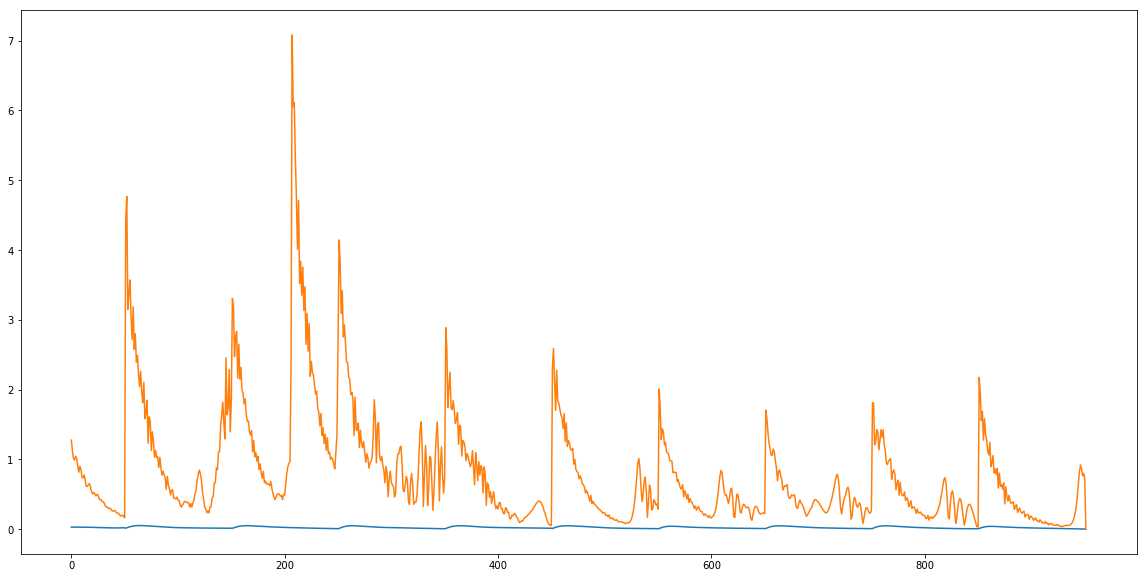

0.00171377023198
0.718941663093


In [27]:
plt.figure(figsize=(20, 10))
plt.plot(SGD_f_M[1][50:])
plt.plot(SGD_f[1][50:])

plt.show()#indexing-view-versus-copy
print SGD_f_M[1][SGD_f_M[1] >0][ -1]
print SGD_f[1][SGD_f[1] >0][ -1]

In [28]:
n = len(name_pca)

w = SGD_f_M[0][:n] # return to original shape
V = SGD_f_M[0][n:].reshape(rang, n).T

In [29]:
start = time.time()
likelihood = LL_f (df_train_t, winner_tr_t, w, V)
end = time.time()
print 'count ll for train data {}'.format(end -start)
print likelihood

count ll for train data 17.9355461597
-1.95275537908


In [30]:
start = time.time()
likelihood = LL_f (df_test_t, winner_ts_t, w, V)
end = time.time()
print 'count ll for test data {}'.format(end -start)
print likelihood

count ll for test data 6.00591301918
-1.96671764084


In [31]:
n = len(name_pca)

w = SGD_f[0][:n] # return to original shape
V = SGD_f[0][n:].reshape(rang, n).T

In [32]:
start = time.time()
likelihood = LL_f (df_train_t, winner_tr_t, w, V)
end = time.time()
print 'count ll for train data {}'.format(end -start)
print likelihood

count ll for train data 18.0997049809
-1.95371461394


In [33]:
start = time.time()
likelihood = LL_f (df_test_t, winner_ts_t, w, V)
end = time.time()
print 'count ll for test data {}'.format(end -start)
print likelihood

count ll for test data 5.91333794594
-1.96544080745


In [63]:
V = SGD_f_M[0][n:].reshape(rang, n).T
np.abs(V.dot(V.T)).max()

0.0025202162249230589

In [65]:
w = SGD_f_M[0][:n]
np.abs(w).max(), np.abs(w).min()

(0.24739312439255562, 0.00020068875932594449)

In [66]:
from thbmodel.prediction.models.St_gradient import *

IndentationError: unindent does not match any outer indentation level (St_gradient.py, line 240)

In [71]:
!python -tt .thbmodel.prediction.models.St_gradient.py

python: can't open file '.thbmodel.prediction.models.St_gradient.py': [Errno 2] No such file or directory
